In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os


In [2]:
from scipy.stats import pearsonr

# Arguments

In [348]:
internal_dim = 16
generic_exp_name = 'altT_eps0.4_tlen8_mlen5'
network_yaml = 'dm'

In [3]:
internal_dim = 32
generic_exp_name = 'altT_eps0.3_tlen10_mlen4_gamma0.7_height8'
network_yaml = 'dm_large_encoder'

In [357]:
internal_dim = 24
generic_exp_name = 'altT_eps0.4_tlen8'
network_yaml = 'dm'

In [14]:
internal_dim = 32
generic_exp_name = 'altT_eps0.4_tlen10_mlen6_gamma0.7'
network_yaml = 'dm_large_q'

# Directories

In [15]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'
exp_name = f'{generic_exp_name}_{network_yaml}_dim{internal_dim}'
analysis_dir = f'{engram_dir}analysis/{exp_name}/'

In [16]:
os.listdir(f'{engram_dir}analysis/')

['gridworld8x8_dm_dim4',
 'altT_eps0.8_tlen8_dm_dim16',
 'gridworld6x6_dm_dim8',
 '.DS_Store',
 'altT_eps0.3_tlen10_mlen4_gamma0.7_height8_dm_large_encoder_dim32',
 'altT_eps0.4_tlen8_mlen5_dm_dim16',
 'altT_eps0.4_tlen10_mlen6_gamma0.7_dm_large_encoder_dim32',
 'altT_eps0.4_tlen8_mlen6_dm_dim32',
 'gridworld8x8_dm_dim2',
 'altT_eps0.4_tlen8_dm_dim24',
 'gridworld8x8_dm_dim3',
 'altT_eps0.5_tlen8_mlen1_dm_dim32',
 'gridworld8x8_dm_dim10',
 'altT_eps0.4_tlen10_mlen6_gamma0.7_dm_large_q_dim32',
 'gridworld8x8_dm_large_q_dim7',
 'altT_eps0.4_tlen10_mlen8_gamma0.8_height8_dm_large_encoder_dim32',
 'gridworld8x8_largeencoder_dm_large_encoder_dim10',
 'gridworld8x8_dm_dim8',
 'altT_eps0.4_tlen10_mlen6_gamma0.8_dm_dim32',
 'altT_eps0.4_tlen8_dm_dim16',
 'gridworld8x8_largeencoder_dm_large_encoder_dim8',
 'altT_eps0.9_tlen10_mlen6_gamma0.8_dm_dim32',
 'altT_eps0.4_tlen10_mlen8_gamma0.8_height8_dm_large_encoder_dim16',
 'gridworld6x6_dm_dim10',
 'gridworld6x6_dm_dim16']

# Load analysis

In [17]:
with open(f'{analysis_dir}representation_df.p', 'rb') as f:
    repr_df = pickle.load(f)

In [18]:
y_locs = np.sort(np.unique(repr_df['y']))
x_locs = np.sort(np.unique(repr_df['x']))
n_y = y_locs.size
midpoint = x_locs[x_locs.size//2]

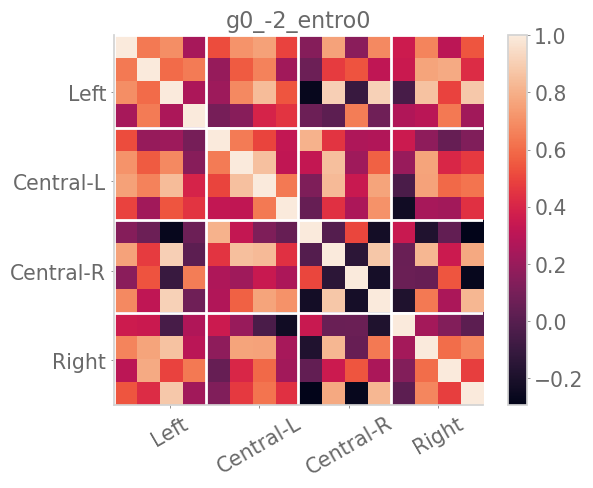

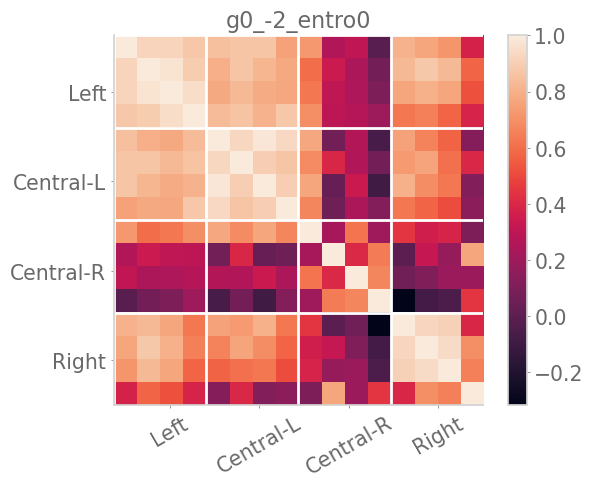

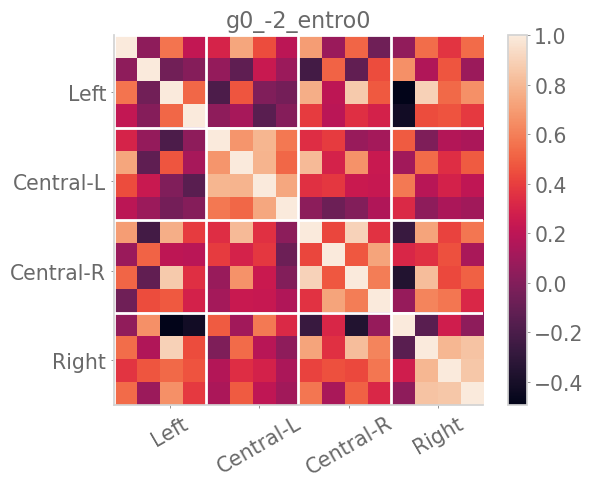

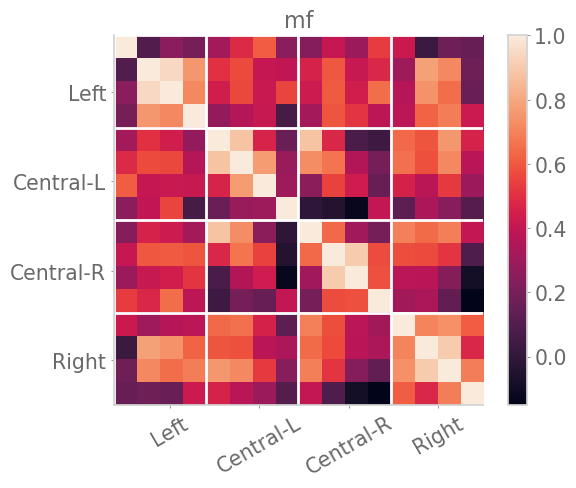

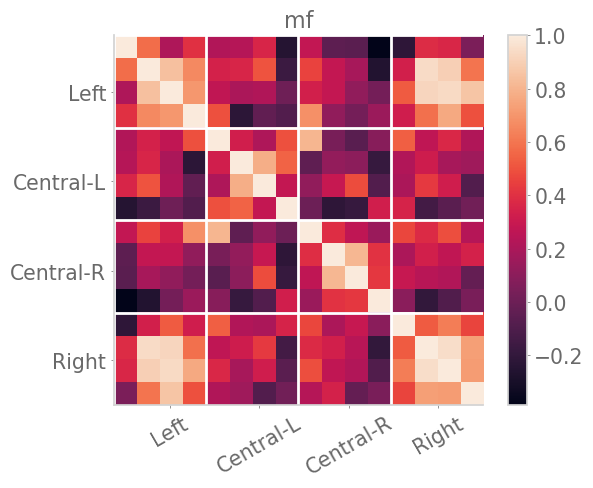

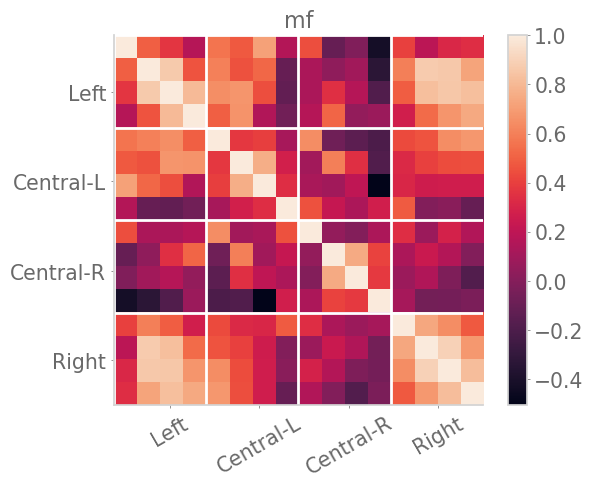

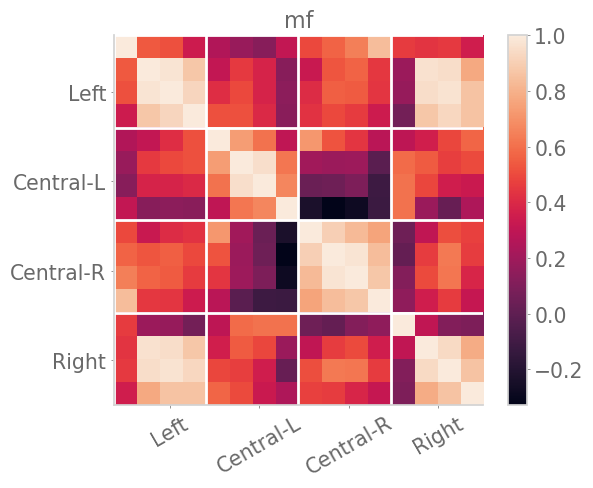

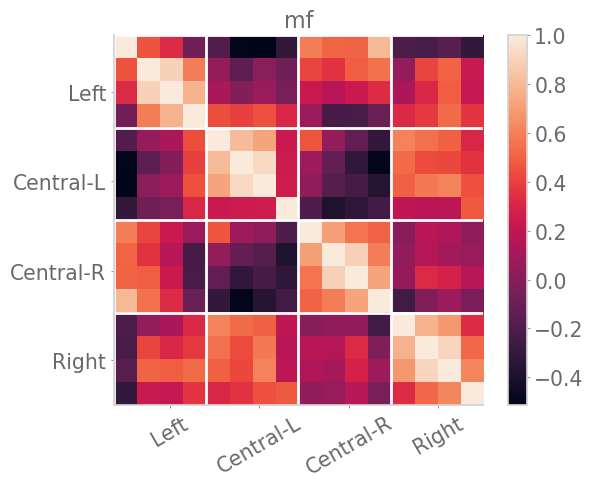

In [19]:
models = []
stem_locs = []
splits = []
iters = []

for model in np.unique(repr_df['model']):
    for iteration in np.unique(repr_df[repr_df['model']==model]['iteration']):
        # Initialize similarity matrix
        sim_mat = np.zeros((n_y*4, n_y*4))*np.nan
        
        # Partition dataset into the four desired conditions
        _df = repr_df[(repr_df['model']==model) & (repr_df['iteration']==iteration)]
        final_reward = _df['final_reward'].iloc[0]
        if final_reward < 100: continue
        _df_L = _df[_df['x']==x_locs[0]]
        _df_LReset = _df[(_df['x']==midpoint) & (_df['reward_loc']==2)]
        _df_RReset = _df[(_df['x']==midpoint) & (_df['reward_loc']==1)]
        _df_R = _df[_df['x']==x_locs[-1]]
        _df_list = [_df_L, _df_LReset, _df_RReset, _df_R]
        
        # Get pairwise differences
        for i, df_i in enumerate(_df_list):
            for j, df_j in enumerate(_df_list):
                if j > i: continue
                for y_i_idx, _y_i in enumerate(y_locs):
                    for y_j_idx, _y_j in enumerate(y_locs):
                        df_i_y = np.array((df_i[df_i['y']==_y_i]['latents']).tolist()).squeeze()
                        df_j_y = np.array((df_j[df_j['y']==_y_j]['latents']).tolist()).squeeze()
                        df_i_y = np.mean(df_i_y, axis=0)
                        df_j_y = np.mean(df_j_y, axis=0)
                        
                        #diff_norm = np.linalg.norm(df_i_y - df_j_y) # Norm difference
                        try:
                            diff_norm, _ = pearsonr(df_i_y, df_j_y) # Pearsonr
                            #diff_norm = 1 - abs(diff_norm)
                        except:
                            continue
                        sim_mat[y_i_idx + i*n_y, y_j_idx + j*n_y] = diff_norm
                        sim_mat[y_j_idx + j*n_y, y_i_idx + i*n_y] = diff_norm
        models.extend([model]*n_y)
        stem_locs.extend(range(n_y))
        reset_mat = sim_mat[n_y:2*n_y, 2*n_y:3*n_y]
        diag = np.diag(reset_mat)
        #diag = diag/diag.mean()
        #diag = diag/diag.max()
        splits.extend(diag.tolist())
        iters.extend([iteration]*n_y)
                        
        plt.figure()
        plt.title(model)
        height = y_locs.size
        plt.imshow(sim_mat)#, vmin=0, vmax=0.9)
        for boundary in [0, height, height*2, height*3]:
            plt.axhline(boundary-0.5, linewidth=2, color='white')
            plt.axvline(boundary-0.5, linewidth=2, color='white')
        plt.xticks(
            np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'], rotation=30)
        plt.yticks(
            np.linspace(0, sim_mat.shape[0]-0.5, num=9, endpoint=True)[1::2],
            ['Left', 'Central-L', 'Central-R', 'Right'])
        plt.colorbar()
        plt.show()

# Collect

In [20]:
dist_df = pd.DataFrame({
    'models': models, 'stem_locs': stem_locs,
    'splits': splits, 'iteration': iters
    })

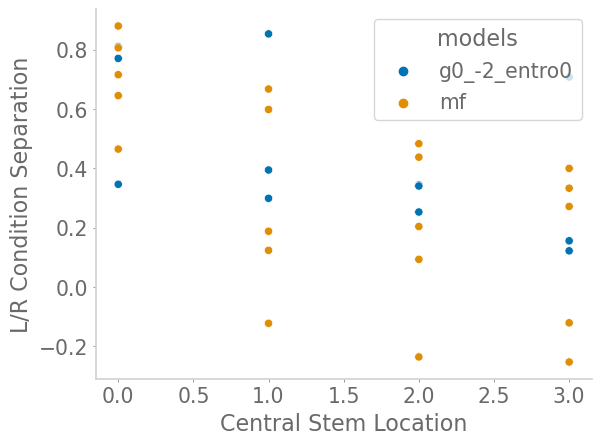

In [21]:
plt.figure()
sns.scatterplot(
    x='stem_locs', y='splits', hue='models', data=dist_df
    )
plt.ylabel('L/R Condition Separation')
plt.xlabel('Central Stem Location')
#plt.ylim(0, 1)
#plt.xticks([0, 2, 4], ['Reset', 'Middle', 'Decision Point'])
plt.show()

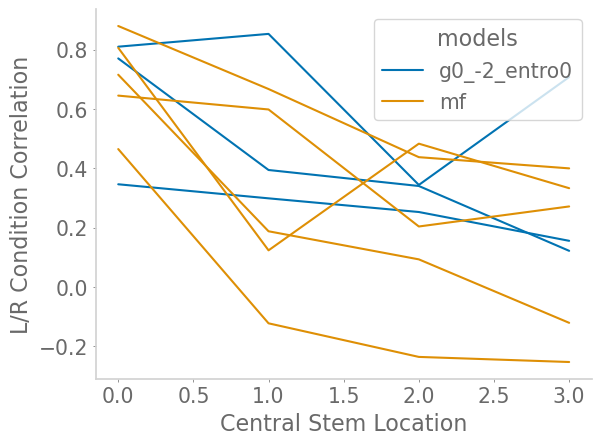

In [24]:
plt.figure()
sns.lineplot(
    x='stem_locs', y='splits', hue='models', data=dist_df,
    units='iteration', estimator=None
    )
plt.ylabel('L/R Condition Correlation')
plt.xlabel('Central Stem Location')
#plt.xticks([0, 2, 4], ['Reset', 'Middle', 'Decision Point'])
plt.show()

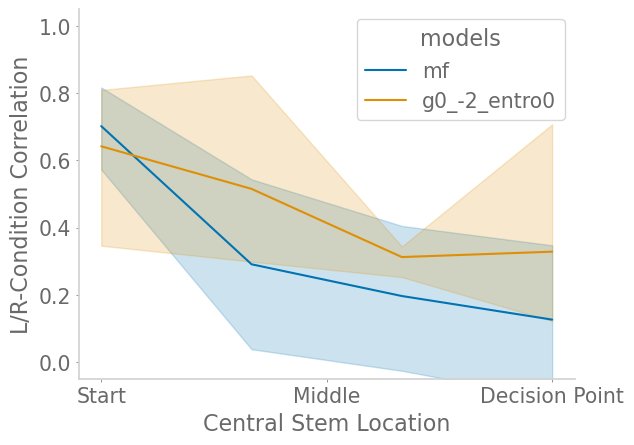

In [23]:
plt.figure()
sns.lineplot(
    x='stem_locs', y='splits', hue='models', data=dist_df, hue_order=['mf', 'g0_-2_entro0']
    )
plt.ylabel('L/R-Condition Correlation')
plt.xlabel('Central Stem Location')
plt.xticks([0, 1.5, 3], ['Start', 'Middle', 'Decision Point'])
plt.ylim(-0.05, 1.05)
plt.show()